**Notebook to retrieve and plot the healsparse coadd depth maps for the 2023-05A,05B AuxTel/LATISS coadd imaging data processed in PREOPS-3463 (https://jira.lsstcorp.org/browse/PREOPS-3463) and DM-39038 (https://jira.lsstcorp.org/browse/DM-39038).**

**Huan Lin,  23 Jun 2023**

In [1]:
# Generic python packages
import numpy as np
import pylab as plt

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler

# Packages for working with sparse healpix maps
import healsparse as hsp
import skyproj

In [2]:
# Check lsst_distrib version.
! eups list -s lsst_distrib

   gdf42428520+6e28b0b2df 	current w_2023_25 setup


In [3]:
# Get datasetRefs from the appropriate repo.

repo = '/repo/embargo'
collection = 'u/huanlin/LATISS/runs/AUXTEL_DRP_IMAGING_2023-05AB/w_2023_21/DM-39038'
butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

datasetRefs = registry.queryDatasets(collections=collection,
                                     datasetType='deepCoadd_psf_maglim_map_weighted_mean')
print(datasetRefs.count())

9


In [4]:
# Make dictionaries containing depth maps and depth values.

maps = {}
depths = {}
for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    tract = ref.dataId['tract']
    band = ref.dataId['band']
    maps[f'tract {tract} band {band}'] = butler.get(ref)
    pixels = maps[f'tract {tract} band {band}'].valid_pixels_pos(return_pixels=True)
    depths[f'tract {tract} band {band}'] = maps[f'tract {tract} band {band}'].get_values_pix(pixels[0])
    del pixels

{band: 'r', skymap: 'latiss_v1', tract: 5634}
{band: 'r', skymap: 'latiss_v1', tract: 5614}
{band: 'g', skymap: 'latiss_v1', tract: 5615}
{band: 'i', skymap: 'latiss_v1', tract: 5615}
{band: 'g', skymap: 'latiss_v1', tract: 5614}
{band: 'g', skymap: 'latiss_v1', tract: 5634}
{band: 'i', skymap: 'latiss_v1', tract: 5634}
{band: 'r', skymap: 'latiss_v1', tract: 5615}
{band: 'i', skymap: 'latiss_v1', tract: 5614}


tract 5614 band g median depth (5-sigma PSF) = 21.427 npixels = 13446
tract 5615 band g median depth (5-sigma PSF) = 21.655 npixels = 14027
tract 5634 band g median depth (5-sigma PSF) = 21.078 npixels = 8478


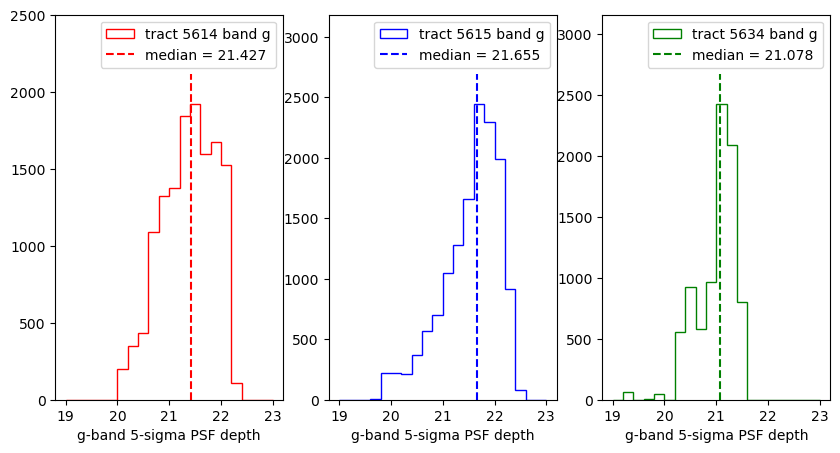

tract 5614 band r median depth (5-sigma PSF) = 21.268 npixels = 13600
tract 5615 band r median depth (5-sigma PSF) = 21.543 npixels = 14391
tract 5634 band r median depth (5-sigma PSF) = 21.104 npixels = 7821


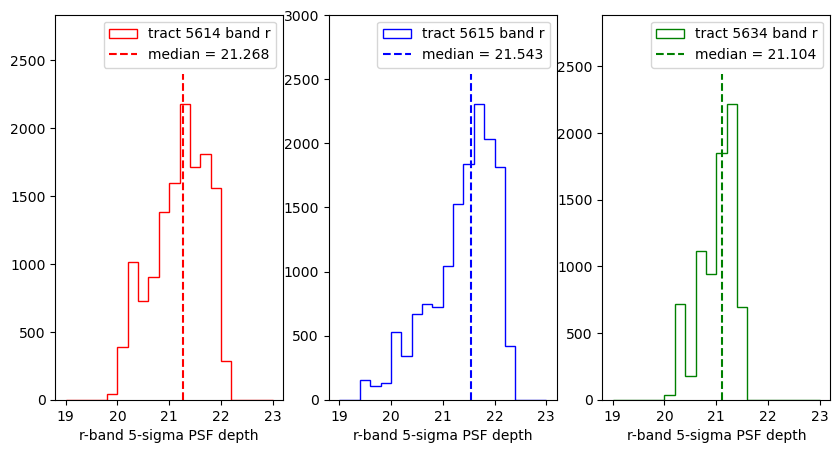

tract 5614 band i median depth (5-sigma PSF) = 21.329 npixels = 13416
tract 5615 band i median depth (5-sigma PSF) = 21.596 npixels = 14024
tract 5634 band i median depth (5-sigma PSF) = 20.826 npixels = 8718


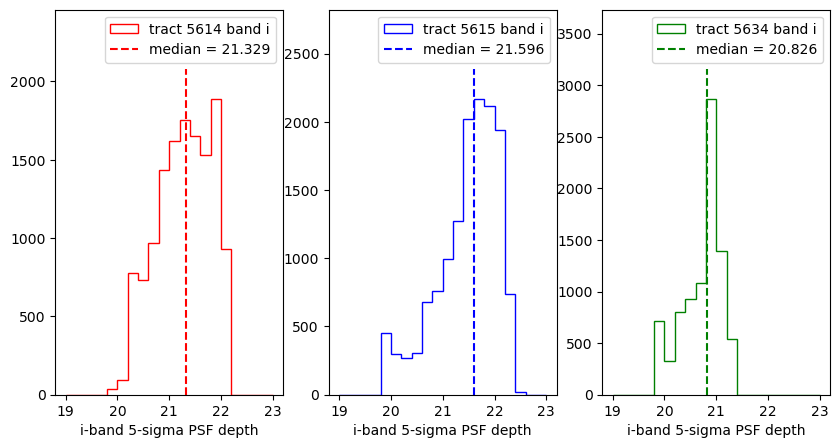

In [5]:
# Plot depth limit histograms, compute median depth limits, and output the plots.

mag1 = 19.
mag2 = 23.
dmag = 0.2
nbins = int((mag2-mag1)/dmag)

tracts = [5614, 5615, 5634]
colors = {'5614': 'red',
          '5615': 'blue',
          '5634': 'green'}
          
bands = ['g', 'r', 'i']

for i, band in enumerate(bands):
    fig, ax = plt.subplots(1, 3, figsize=(10,5))

    for j, tract in enumerate(tracts):
        n, bins, patches = ax[j].hist(depths[f'tract {tract} band {band}'], range=(mag1, mag2), 
                                      bins=nbins, histtype='step', label=f'tract {tract} band {band}',
                                      color=colors[f'{tract}'])
        
        med = np.median(depths[f'tract {tract} band {band}'])
        npix = depths[f'tract {tract} band {band}'].shape[0]

        vmin = np.amin(n)
        vmax = np.amax(n)
        ax[j].vlines(med,vmin,vmax*1.1, color=colors[f'{tract}'], linestyle='dashed',
                     label=f'median = {med:6.3f}')
        ax[j].set_ylim(0,vmax*1.3)
        ax[j].set_xlabel(f'{band}-band 5-sigma PSF depth')
        ax[j].legend(loc='best')

        print(f'tract {tract} band {band} median depth (5-sigma PSF) = {med:6.3f} npixels = {npix}')
        
        plt.savefig(f"depths_{band}.png", bbox_inches='tight', dpi=300)
    plt.show()

tract 5614 band g


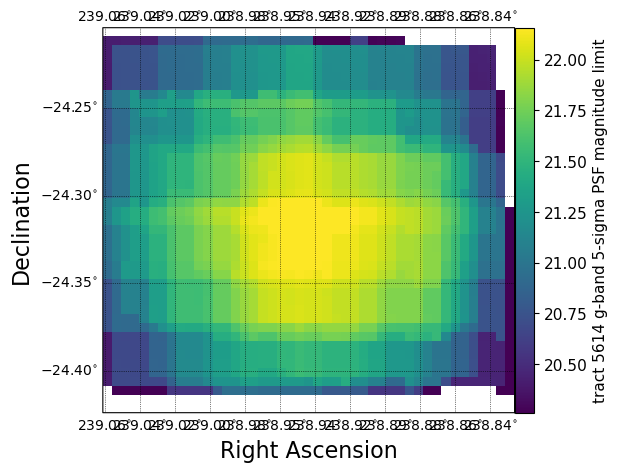

tract 5615 band g


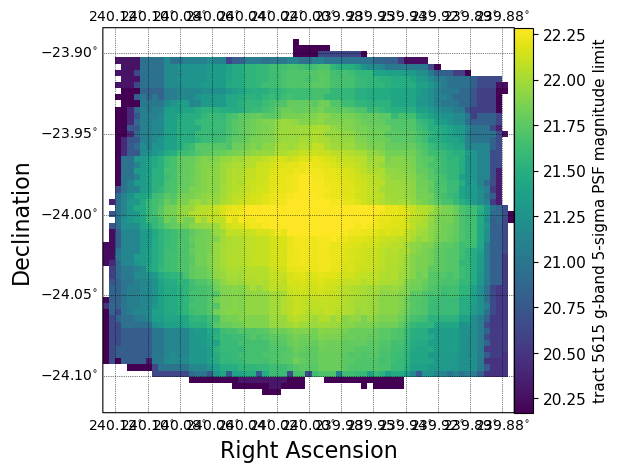

tract 5634 band g


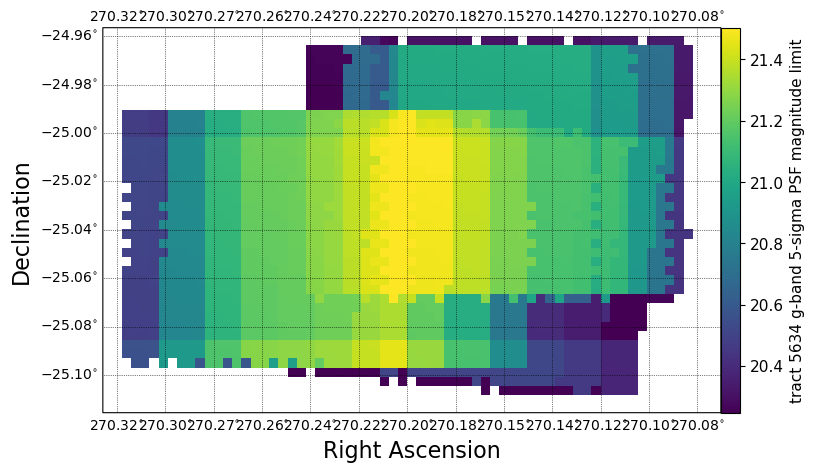

tract 5614 band r


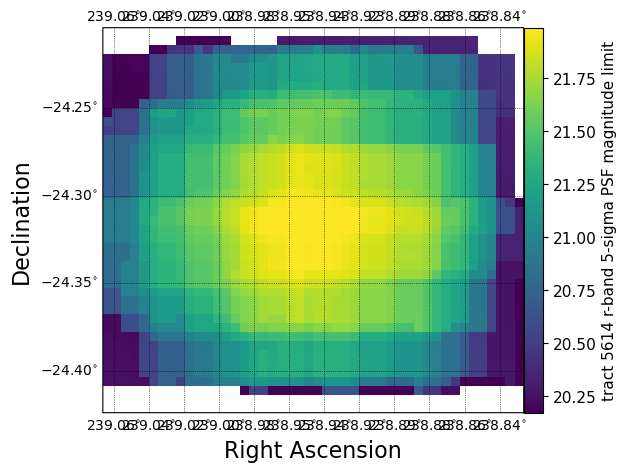

tract 5615 band r


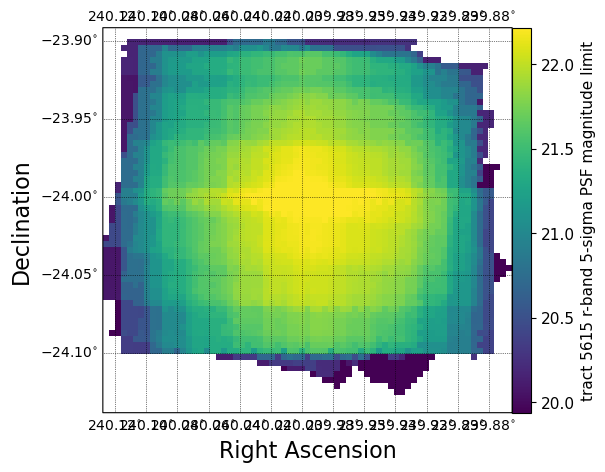

tract 5634 band r


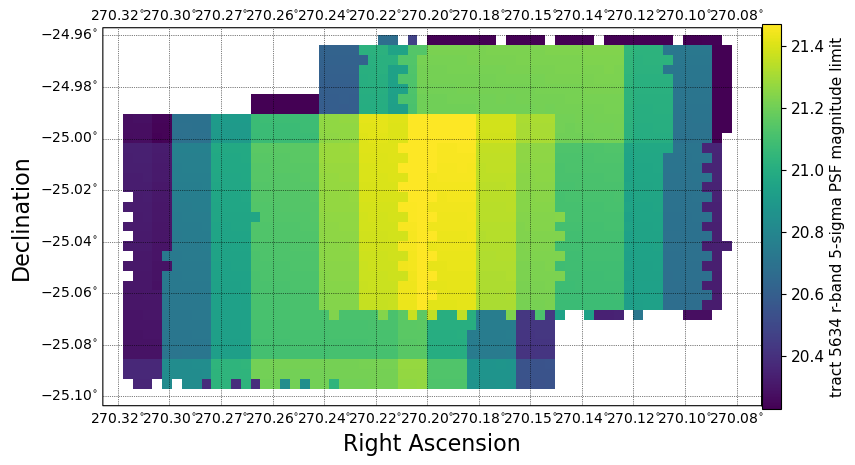

tract 5614 band i


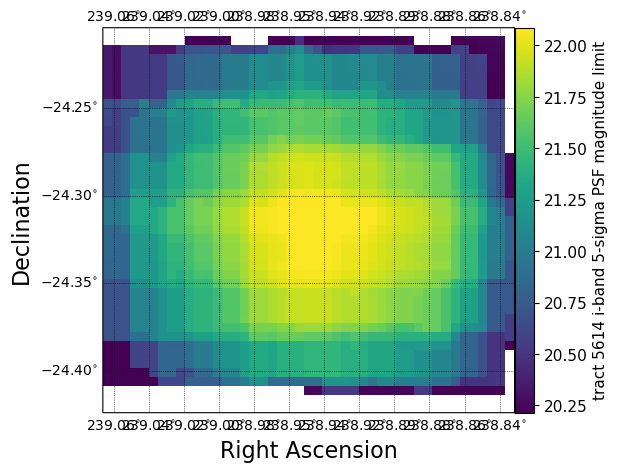

tract 5615 band i


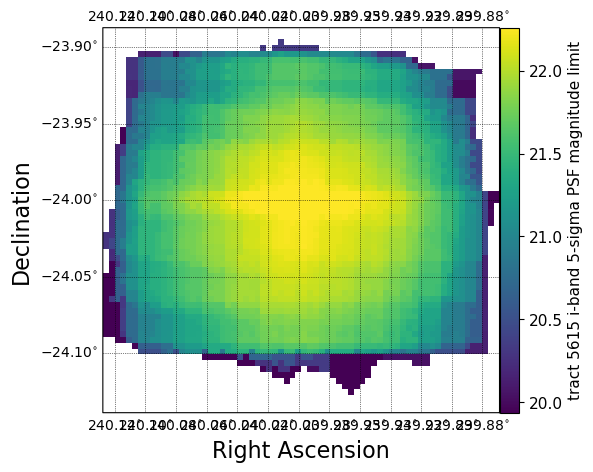

tract 5634 band i


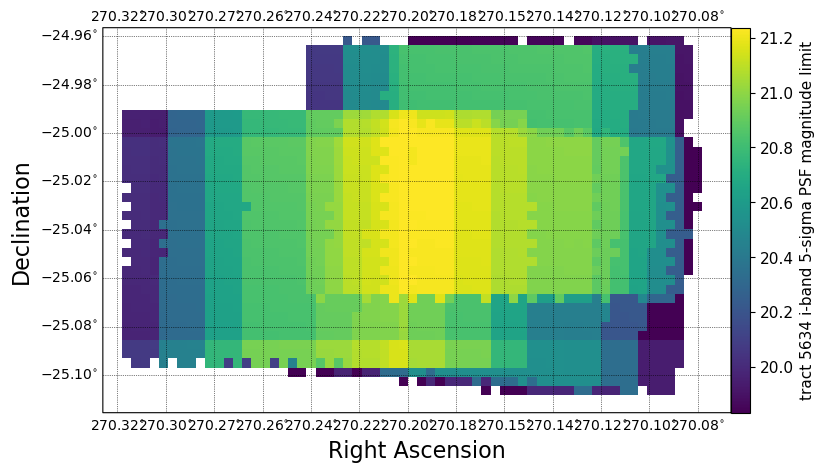

In [6]:
# Plot depth maps and output the plots.

for i, band in enumerate(bands):
    for j, tract in enumerate(tracts):
        print(f'tract {tract} band {band}')

        fig, ax = plt.subplots(figsize=(10,5))
        sp = skyproj.Skyproj(ax=ax)
        sp.draw_hspmap(maps[f'tract {tract} band {band}'])
        sp.draw_colorbar(label=f"tract {tract} {band}-band 5-sigma PSF magnitude limit")
        plt.savefig(f"depths_{tract}_{band}.png", bbox_inches='tight', dpi=300)
        plt.show()
    